In [1]:
from train import *
from processing import find_estado_with_value_two
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import pandas as pd
import xgboost as xgb
import random
import shap
pd.set_option('display.max_columns', None)
random.seed(10)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Baseline Model

In [2]:
df = build_dataset_with_features(categorical_features= False,climate_features=False)
train, val, test = train_test_val_split(df)

In [3]:
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [4]:
metrics_dictionary = {}
def get_metrics_train_val(model, name, print_metrics=True):
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    
    train_mse = round(mean_squared_error(y_train, y_pred_train), 2)
    val_mse = round(mean_squared_error(y_val, y_pred_val), 2)
    val_mse_discrete = round(mse_score_discrete(y_val, y_pred_val), 2)

    if print_metrics:
        print('Train MSE {}: {}'.format(name, train_mse))
        print('Validation MSE {}: {}'.format(name, val_mse))
        print('Validation MSE Discrete {}: {}'.format(name, val_mse_discrete))

    return train_mse, val_mse, val_mse_discrete, model


In [5]:

x_val["estado_actual"] = x_val[estados].apply(find_estado_with_value_two, axis=1)
train["estado_actual"] = train[estados].apply(find_estado_with_value_two, axis=1)
x_train["estado_actual"] = x_train[estados].apply(find_estado_with_value_two, axis=1)

mode_dict = train.groupby('estado_actual')['next_y'].apply(lambda x: x.mode().iloc[0]).to_dict()
y_pred_baseline = x_val['estado_actual'].map(mode_dict)
y_pred_baseline_train = x_train['estado_actual'].map(mode_dict)


print('Train MSE baseline: {}'.format(metrics.mean_squared_error(y_train, y_pred_baseline_train)))
print('Validation MSE baseline: {}'.format(metrics.mean_squared_error(y_val, y_pred_baseline)))
print('Validation MSE discrete baseline: {}'.format(mse_score_discrete(y_val, y_pred_baseline)))
metrics_dictionary['Baseline'] = [round(metrics.mean_squared_error(y_train, y_pred_baseline_train),2), 
                                  round(metrics.mean_squared_error(y_val, y_pred_baseline), 2),
                                  round(mse_score_discrete(y_val, y_pred_baseline), 2)]

x_val.drop('estado_actual', axis=1, inplace=True)
train.drop('estado_actual', axis=1, inplace=True)
x_train.drop('estado_actual', axis=1, inplace=True)

Train MSE baseline: 0.4392063322764456
Validation MSE baseline: 0.3942102531572574
Validation MSE discrete baseline: 0.3942102531572574


In [6]:
pd.DataFrame(list(mode_dict.items()), columns=['Current Estado', 'Y_pred_baseline'])

,Current Estado,Y_pred_baseline
0,1,1
1,2,1
2,3,1
3,4,2
4,5,2
5,6,2
6,7,2
7,8,1
8,9,0
9,10,0


### Models for non-categorical variables parcela

In [7]:
basic_reg_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression()) 
])

basic_reg_model.fit(x_train, y_train)

metrics_dictionary['LinearRegression Non-Categorical Parcelas'] = get_metrics_train_val(basic_reg_model, "Linear Regression")

coefficients = basic_reg_model.named_steps['regressor'].coef_

print("\n Coefficients:")
for feature, coef in zip(x_train.columns, coefficients):
    print(f"{feature}: {round(coef,4)}")

Train MSE Linear Regression: 0.34
Validation MSE Linear Regression: 0.33
Validation MSE Discrete Linear Regression: 0.42

 Coefficients:
104_altitud_(m): -0.001
201_superf_cultivada_en_la_parcela_agrícola_(ha): 0.0057
202_pendiente_(%): 0.0045
301_marco_(m_x_m): 0.0004
302_densidad_(plantas/ha): -0.0021
303_nº_pies_por_árbol: 0.0035
porcentaje_floracion: 0.0029
211_utilización_de_cubierta_vegetal: -0.003
208_riego:_procedencia_del_agua: -0.0028
207_riego:_sistema_usual_de_riego: 0.0016
109_sistema_para_el_cumplimiento_gestión_integrada: 0.0039
estado_fenologico_1: 0.0803
estado_fenologico_2: 0.0995
estado_fenologico_3: 0.204
estado_fenologico_4: 0.2554
estado_fenologico_5: 0.2067
estado_fenologico_6: 0.1842
estado_fenologico_7: 0.234
estado_fenologico_8: 0.0868
estado_fenologico_9: 0.0368
estado_fenologico_10: -0.0597
estado_fenologico_11: 0.1322
estado_fenologico_12: 0.0315
estado_fenologico_13: 0.0037
estado_fenologico_14: -0.0037
number_days_current_estado: 0.0876


In [8]:
def run_ridge_models():
    param_grid = [0.001, 0.01, 0.1, 1, 10, 100]
    
    for alpha in param_grid:
        reg_model = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Ridge(alpha=alpha))])

        reg_model.fit(x_train, y_train)
        
        get_metrics_train_val(reg_model, f"Ridge (alpha = {alpha})")

run_ridge_models()

Train MSE Ridge (alpha = 0.001): 0.34
Validation MSE Ridge (alpha = 0.001): 0.33
Validation MSE Discrete Ridge (alpha = 0.001): 0.42
Train MSE Ridge (alpha = 0.01): 0.34
Validation MSE Ridge (alpha = 0.01): 0.33
Validation MSE Discrete Ridge (alpha = 0.01): 0.42
Train MSE Ridge (alpha = 0.1): 0.34
Validation MSE Ridge (alpha = 0.1): 0.33
Validation MSE Discrete Ridge (alpha = 0.1): 0.42
Train MSE Ridge (alpha = 1): 0.34
Validation MSE Ridge (alpha = 1): 0.33
Validation MSE Discrete Ridge (alpha = 1): 0.42
Train MSE Ridge (alpha = 10): 0.34
Validation MSE Ridge (alpha = 10): 0.33
Validation MSE Discrete Ridge (alpha = 10): 0.42
Train MSE Ridge (alpha = 100): 0.34
Validation MSE Ridge (alpha = 100): 0.33
Validation MSE Discrete Ridge (alpha = 100): 0.42


In [9]:
def run_lasso_models():
    param_grid = [0.001, 0.01, 0.1, 1, 10, 100]
    
    for alpha in param_grid:
        reg_model = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Lasso(alpha=alpha))])

        reg_model.fit(x_train, y_train)
        
        get_metrics_train_val(reg_model, f"Ridge (alpha = {alpha})")

run_lasso_models()

Train MSE Ridge (alpha = 0.001): 0.34
Validation MSE Ridge (alpha = 0.001): 0.33
Validation MSE Discrete Ridge (alpha = 0.001): 0.42
Train MSE Ridge (alpha = 0.01): 0.34
Validation MSE Ridge (alpha = 0.01): 0.32
Validation MSE Discrete Ridge (alpha = 0.01): 0.42
Train MSE Ridge (alpha = 0.1): 0.4
Validation MSE Ridge (alpha = 0.1): 0.37
Validation MSE Discrete Ridge (alpha = 0.1): 0.51
Train MSE Ridge (alpha = 1): 0.67
Validation MSE Ridge (alpha = 1): 0.64
Validation MSE Discrete Ridge (alpha = 1): 0.76
Train MSE Ridge (alpha = 10): 0.67
Validation MSE Ridge (alpha = 10): 0.64
Validation MSE Discrete Ridge (alpha = 10): 0.76
Train MSE Ridge (alpha = 100): 0.67
Validation MSE Ridge (alpha = 100): 0.64
Validation MSE Discrete Ridge (alpha = 100): 0.76


In [10]:
n_trees_grid = [5,25,50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    metrics_dictionary['Random Forest Non-Categorical Parcelas'] = get_metrics_train_val(rf,f"Random Forest Regressor (n_trees = {n_trees})")


Train MSE Random Forest Regressor (n_trees = 5): 0.14
Validation MSE Random Forest Regressor (n_trees = 5): 0.32
Validation MSE Discrete Random Forest Regressor (n_trees = 5): 0.38
Train MSE Random Forest Regressor (n_trees = 25): 0.13
Validation MSE Random Forest Regressor (n_trees = 25): 0.29
Validation MSE Discrete Random Forest Regressor (n_trees = 25): 0.35
Train MSE Random Forest Regressor (n_trees = 50): 0.13
Validation MSE Random Forest Regressor (n_trees = 50): 0.28
Validation MSE Discrete Random Forest Regressor (n_trees = 50): 0.35


In [11]:
learning_rates = [0.001, 0.01, 0.1, 1]
depths = [1, 5, 10]
n_trees = [5, 25, 50, 100]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete, model = get_metrics_train_val(xgb_model,f'Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 1, 'max_depth': 10, 'n_trees': 100}
{'train_mse': 0.15, 'val_mse': 0.35, 'val_mse_discrete': 0.4}


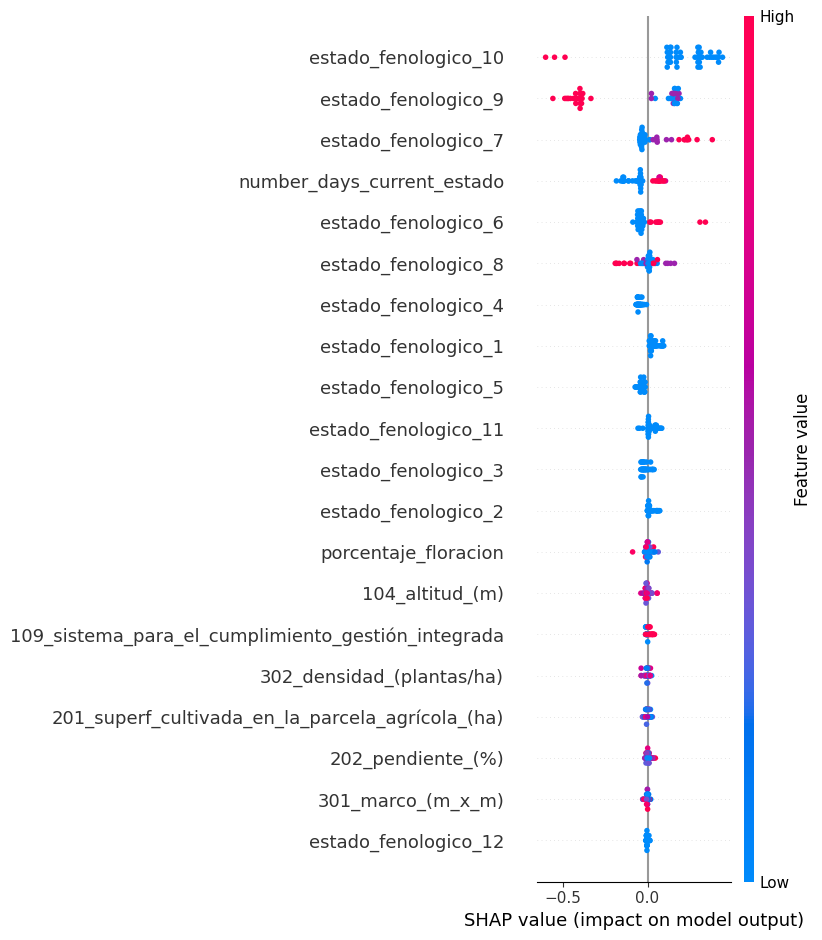

In [12]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(x_val[:50])
shap.summary_plot(shap_values, x_val[:50])

In [13]:
#Best predicitons of the model
y_pred = rf.predict(x_test)
y_pred_rounded = []

for pred in y_pred:
    if pred - int(pred) < 0.5:
        y_pred_rounded.append(max(0, math.floor(pred)))
    else:
        y_pred_rounded.append(max(0, math.ceil(pred)))

y_final = y_test - y_pred_rounded

print(y_final.value_counts())

next_y
 0    31690
-1     5683
 1     4499
-2      469
 2      230
 3       25
-3       10
 4        3
 5        2
 7        1
Name: count, dtype: int64


### Best Models Parcela With Categorical Features

In [14]:
df_all_parcelas = build_dataset_with_features(climate_features=False)

In [15]:
categorical_columns = [
        "campaña",
        "105_comarca",
        "203_orientación",
        "204_textura_del_suelo",
        "206_secano_/_regadío",
        "212_tipo_de_cubierta_vegetal",
        "304_formación",
        "308_variedad_principal",
        "120_zona_biológica_raif",
        "310_patrón_variedad_principal",
    ]
df_all_parcelas[categorical_columns] = df_all_parcelas[categorical_columns].astype("category")
# Resulting DataFrame with one-hot encoding
df_encoded = pd.get_dummies(df_all_parcelas, columns=categorical_columns)


train, val, test = train_test_val_split(df_encoded)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    metrics_dictionary['Random Forest All Variables Parcelas'] = get_metrics_train_val(rf,f"Random Forest All Variables Parcelas (n_trees = {n_trees})")

Train MSE Random Forest All Variables Parcelas (n_trees = 5): 0.08
Validation MSE Random Forest All Variables Parcelas (n_trees = 5): 0.3
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 5): 0.35
Train MSE Random Forest All Variables Parcelas (n_trees = 25): 0.07
Validation MSE Random Forest All Variables Parcelas (n_trees = 25): 0.27
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 25): 0.32
Train MSE Random Forest All Variables Parcelas (n_trees = 50): 0.06
Validation MSE Random Forest All Variables Parcelas (n_trees = 50): 0.27
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 50): 0.32


In [16]:
learning_rates = [0.1]
depths = [25, 50]
n_trees = [25, 50,]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete, model = get_metrics_train_val(xgb_model,f'All Parcelas: Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 0.1, 'max_depth': 50, 'n_trees': 50}
{'train_mse': 0.04, 'val_mse': 0.3, 'val_mse_discrete': 0.35}


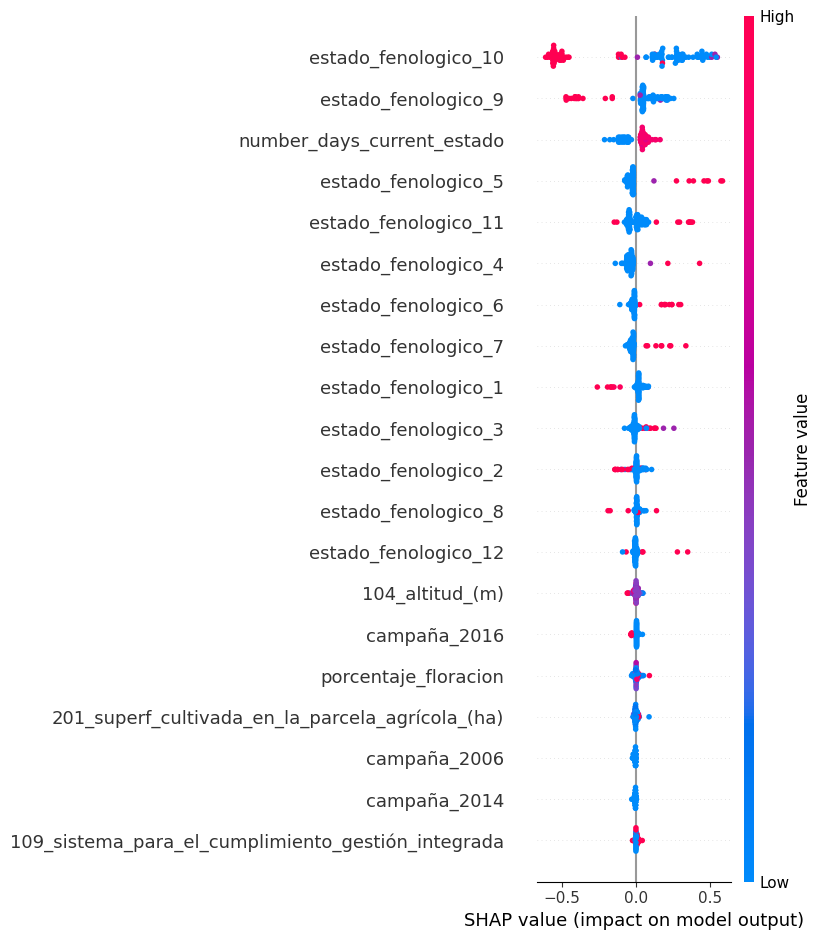

In [17]:
explainer = shap.Explainer(rf)
sample_xval = x_val.sample(100)
shap_values = explainer.shap_values(sample_xval)
shap.summary_plot(shap_values, sample_xval)

### Models Climatic + Parcelas

In [18]:
df_climatic = build_dataset_with_features(categorical_features=False)

train, val, test = train_test_val_split(df_climatic)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [19]:
n_trees_grid = [50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    metrics_dictionary['Random Forest Non-Categorical Parcela + Climatic'] = get_metrics_train_val(rf,f"Random Forest Regressor Climatic (n_trees = {n_trees})")

Train MSE Random Forest Regressor Climatic (n_trees = 50): 0.02
Validation MSE Random Forest Regressor Climatic (n_trees = 50): 0.24
Validation MSE Discrete Random Forest Regressor Climatic (n_trees = 50): 0.3


In [20]:
learning_rates = [0.1]
depths = [25, 50]
n_trees = [25]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete, model = get_metrics_train_val(xgb_model,f'Climatic: Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 0.1, 'max_depth': 50, 'n_trees': 25}
{'train_mse': 0.01, 'val_mse': 0.28, 'val_mse_discrete': 0.35}


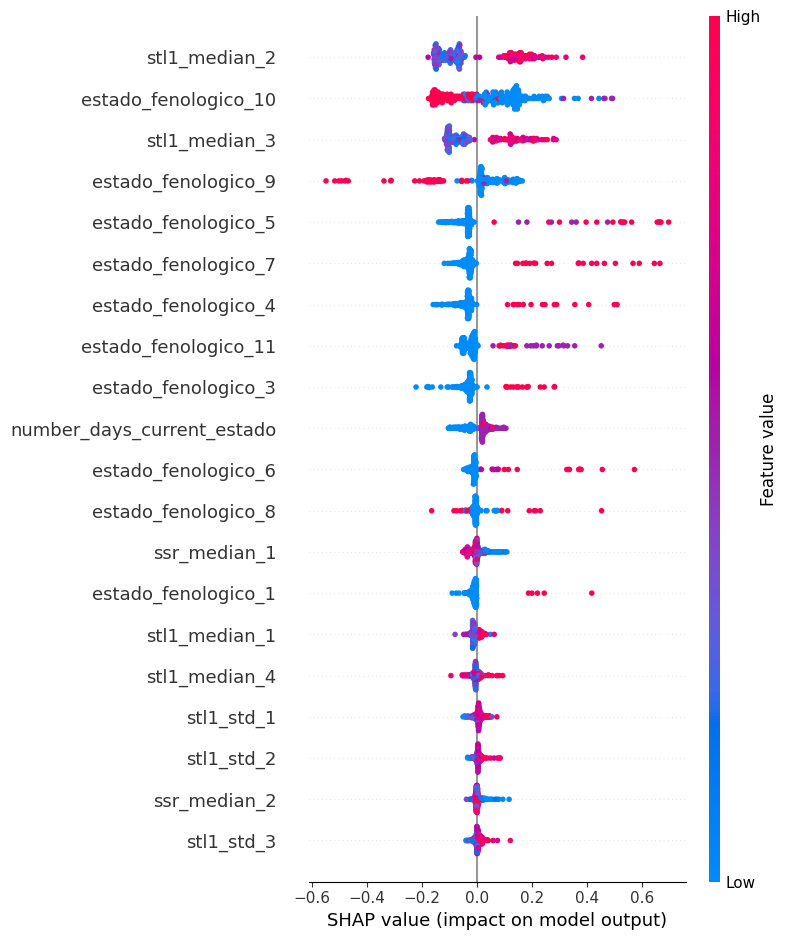

In [21]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(x_val[:250])
shap.summary_plot(shap_values, x_val[:250])

### Model just climatic Variables + growth-stage variables

In [22]:
df_only_climatic = build_dataset_with_features(categorical_features=False, binary_features=False, numeric_features=False)

train, val, test = train_test_val_split(df_only_climatic)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [23]:
n_trees_grid = [50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    metrics_dictionary['Random Forest Climatic + Estados Parcela Features'] = get_metrics_train_val(rf,f"Random Forest Regressor Only Climatic (n_trees = {n_trees})")


Train MSE Random Forest Regressor Only Climatic (n_trees = 50): 0.02
Validation MSE Random Forest Regressor Only Climatic (n_trees = 50): 0.24
Validation MSE Discrete Random Forest Regressor Only Climatic (n_trees = 50): 0.3


### Results

In [24]:
rows = []

for name in metrics_dictionary.keys():
    metrics = metrics_dictionary[name]
    row_data = {'Model': name, 'Train MSE': metrics[0], 'Validation MSE': metrics[1], 'Discrete Validation MSE': metrics[2]}
    rows.append(row_data)

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(by='Validation MSE')
df_metrics


,Model,Train MSE,Validation MSE,Discrete Validation MSE
4,Random Forest Non-Categorical Parcela + Climatic,0.02,0.24,0.30
5,Random Forest Climatic + Estados Parcela Features,0.02,0.24,0.30
3,Random Forest All Variables Parcelas,0.06,0.27,0.32
2,Random Forest Non-Categorical Parcelas,0.13,0.28,0.35
1,LinearRegression Non-Categorical Parcelas,0.34,0.33,0.42
0,Baseline,0.44,0.39,0.39


### Test Results

In [25]:
y_pred_test = rf.predict(x_test)

y_pred_rounded = []

for pred in y_pred_test:
    if pred - int(pred) < 0.5:
        y_pred_rounded.append(max(0, math.floor(pred)))
    else:
        y_pred_rounded.append(max(0, math.ceil(pred)))

diff = y_test - y_pred_rounded
print(pd.Series(diff).value_counts())

next_y
 0.0    5618
-1.0    1358
 1.0    1033
-2.0      99
 2.0      54
 3.0       4
 4.0       1
Name: count, dtype: int64


In [26]:
#Real y
print(y_test.value_counts())

next_y
0.0    4039
1.0    3170
2.0     823
3.0     129
4.0       4
5.0       1
6.0       1
Name: count, dtype: int64


In [27]:
#MSE Test for best model
print(mean_squared_error(y_test,y_pred_rounded))

0.37406636463817805


In [28]:
#MSE Test for baseline

x_test["estado_actual"] = x_test[estados].apply(find_estado_with_value_two, axis=1)
y_pred_baseline = x_test['estado_actual'].map(mode_dict)

print(mean_squared_error(y_test,y_pred_baseline))

0.5108362923962287
